In [1]:
from pathlib import Path

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pymc_bart as pmb
import torch 
from sklearn.model_selection import train_test_split

In [2]:
coal = np.loadtxt(pm.get_data("coal.csv"))

In [3]:
# discretize data
years = int(coal.max() - coal.min())
bins = years // 4
hist, x_edges = np.histogram(coal, bins=bins)
# compute the location of the centers of the discretized data
x_centers = x_edges[:-1] + (x_edges[1] - x_edges[0]) / 2
# xdata needs to be 2D for BART
x_data = x_centers[:, None]
# express data as the rate number of disaster per year
y_data = hist

In [4]:
with pm.Model() as model_coal:
    _μ = pmb.BART("_μ", X=x_data, Y=np.log(y_data), m=20)
    μ = pm.Deterministic("μ", pm.math.exp(_μ))
    y_pred = pm.Poisson("y_pred", mu=μ, observed=y_data)
    idata_coal = pm.sample(random_seed=10)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


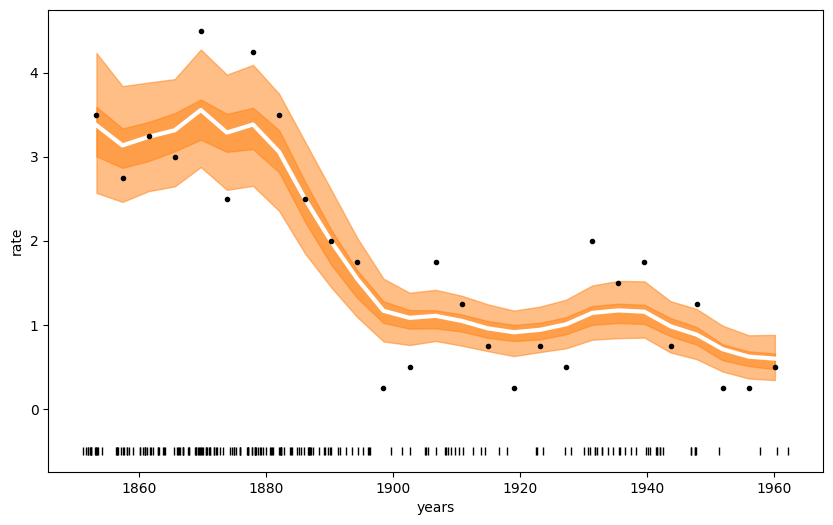

In [5]:
_, ax = plt.subplots(figsize=(10, 6))

rates = idata_coal.posterior["μ"] / 4
rate_mean = rates.mean(dim=["draw", "chain"])
ax.plot(x_centers, rate_mean, "w", lw=3)
ax.plot(x_centers, y_data / 4, "k.")
az.plot_hdi(x_centers, rates, smooth=False)
az.plot_hdi(x_centers, rates, hdi_prob=0.5, smooth=False, plot_kwargs={"alpha": 0})
ax.plot(coal, np.zeros_like(coal) - 0.5, "k|")
ax.set_xlabel("years")
ax.set_ylabel("rate");

array([[<AxesSubplot:title={'center':'_μ'}>,
        <AxesSubplot:title={'center':'_μ'}>],
       [<AxesSubplot:title={'center':'μ'}>,
        <AxesSubplot:title={'center':'μ'}>]], dtype=object)

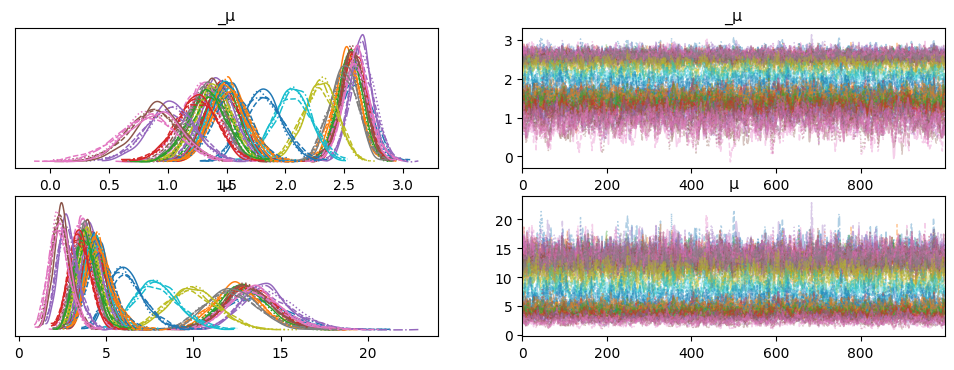

In [6]:
az.plot_trace(idata_coal)

In [7]:
n_host_sample = 100 
sigma_error = 1 
d = 10 
A = torch.randn((d,d))
A = 1/(torch.det(A)) * A

T_allocation_host = torch.randn(d)
T_allocation_host = 100/torch.norm(T_allocation_host)*T_allocation_host

mu_nc = torch.randn(d)
mu_nc = 1/torch.norm(mu_nc)*mu_nc

mu_c = torch.randn(d)
mu_c = 1/torch.norm(mu_c)*mu_c

mu = torch.concat([mu_nc,mu_c])


X_host_no_T = (torch.randn((n_host_sample,d)) @ A ) 
T_host = torch.bernoulli(torch.sigmoid(X_host_no_T@ T_allocation_host))
X_host_times_T = (T_host.unsqueeze(dim=0).T * X_host_no_T)
X_host = torch.concat([X_host_no_T,X_host_times_T],dim=1)

Y_host = X_host @ mu
Y_host = (1/Y_host.norm()) * Y_host + sigma_error * torch.randn_like(Y_host)

In [10]:
with pm.Model() as model_host:
    μ = pmb.BART("_μ", X=np.array(X_host), Y = np.array(Y_host), m=20)
    y_pred = pm.Normal("y_pred", mu=μ, observed=np.array(Y_host))
    idata_host = pm.sample(random_seed=10)

Multiprocess sampling (4 chains in 4 jobs)
PGBART: [_μ]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 6 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


In [9]:
idata_host

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data